**Experiment: Effect of Pruning on Mutual Information in Deep Neural Networks**

**Goal**<br>
This notebook implements the experiments discussed in the accompanying report. The primary goal is to visualize and analyze the effect of *network pruning* on the *information plane* (Mutual Information I(X;H) vs. I(Y;H)) for a multilayer perceptron (MLP) trained on a subset of the MNIST dataset (projected to 12 dimensions using PCA).

**Methodology**<br>
1.  **Baseline Model:** Train a standard MLP (4 hidden layers with `tanh` activation) on MNIST digits 0 and 2 (PCA reduced) and compute the information plane dynamics during training.
2.  **Pruned Model:** Define an identical MLP architecture but apply different *pruning techniques at initialization* (before training starts).
3.  **Pruning Techniques Explored (Code in Cell 6):**
    *   **Weight Pruning (Unstructured L1):** Removes individual weights based on magnitude (`prune.L1Unstructured`). Tested layer-wise and globally.
    *   **Neuron Pruning (Structured L2):** Removes entire neurons based on the L2 norm of their weights (`prune.ln_structured`). Tested layer-wise and globally.
    *   *(Note: The specific pruning method and amount can be adjusted in Cell 6)*
4.  **Training & Analysis:** Train the pruned model and compute its information plane dynamics.
5.  **Comparison:** Compare the information planes and accuracy curves of the baseline and pruned models, relating them to the findings in the report (Figures 1-7).

**Mutual Information Calculation**<br>
Mutual information I(X;H) and I(Y;H) are estimated empirically by discretizing the continuous activation values (H) and input data (X) into `n_bins` (a hyperparameter). The calculations use the standard MI formulas involving the joint and marginal probabilities estimated from the discretized data during training (implemented in Cells 5 and 7):
*   `I(X;H) = sum( p(x,h) * log2( p(x,h) / (p(x) * p(h)) ) )`
*   `I(Y;H) = sum( p(y,h) * log2( p(y,h) / (p(y) * p(h)) ) )`

*Before you start, make sure to change the runtime type to include a GPU!*

<br>

**Reference Report:** "Effect of Pruning on Mutual Information in Deep Neural Networks"

In [ ]:
import math
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.models as models
import torch.nn.utils.prune as prune

from collections import Counter
from sklearn.decomposition import PCA
from torch.utils.data import TensorDataset
from torchvision import datasets, transforms

In [ ]:
# hyperparameters
device        = 'cuda'
lr            = 7e-2
epochs        = 10
milestones    = [epochs//2]
gamma         = 0.5
batch_size    = 512
momentum      = 0
weight_decay  = 0
n_bins        = 25

**1. Baseline Model Setup and Data Preparation**

This section defines the baseline MLP architecture (4 hidden layers with `tanh` activations), sets up hyperparameters, and prepares the dataset.

**Dataset:**
*   MNIST digits '0' and '2' are selected for binary classification.
*   Labels are mapped to 0 and 1.
*   Input images (flattened 28x28) are reduced to 12 dimensions using Principal Component Analysis (PCA) fit on the training set.
*   Standard PyTorch DataLoaders are created for training and testing.

**Hyperparameters:** (Defined in Cell 3)
*   Learning Rate, Epochs, Batch Size, etc.
*   `n_bins`: Number of bins used for discretizing activations for MI calculation.

In [ ]:
# deep network
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(12, 10)
        self.fc2 = nn.Linear(10, 7)
        self.fc3 = nn.Linear(7, 5)
        self.fc4 = nn.Linear(5, 4)
        self.fc5 = nn.Linear(4, 3)
        self.fc6 = nn.Linear(3, 2)

    def forward(self, x):
        h1 = torch.tanh(self.fc1(x))
        h2 = torch.tanh(self.fc2(h1))
        h3 = torch.tanh(self.fc3(h2))
        h4 = torch.tanh(self.fc4(h3))
        h5 = torch.tanh(self.fc5(h4))
        h6 = F.log_softmax(self.fc6(h5), dim=1)
        return h1, h2, h3, h4, h5, h6

model = Model().to(device)




def process_dataset(dataset):
    # keep only images of two digits
    digit1 = 0
    digit2 = 2

    indices = (dataset.targets == digit1) | (dataset.targets == digit2)
    dataset.data, dataset.targets = dataset.data[indices], dataset.targets[indices]

    dataset.targets[dataset.targets == digit1] = 0
    dataset.targets[dataset.targets == digit2] = 1

    dataset = TensorDataset(dataset.data.reshape(-1, 28*28), dataset.targets)

    return dataset

transform = transforms.ToTensor()
train_dataset = process_dataset(datasets.MNIST('../data', download=True, train=True, transform=transform))
test_dataset = process_dataset(datasets.MNIST('../data', download=True, train=False, transform=transform))

# use PCA to reduce to 12 dimensions
pca = PCA(n_components=12)
pca.fit(train_dataset.tensors[0])
train_dataset.tensors = (torch.from_numpy(pca.transform(train_dataset.tensors[0])).float(), train_dataset.tensors[1])
test_dataset.tensors = (torch.from_numpy(pca.transform(test_dataset.tensors[0])).float(), test_dataset.tensors[1])

# dataset loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

train_loader_full = torch.utils.data.DataLoader(
    train_dataset, batch_size=len(train_loader.dataset), shuffle=False, drop_last=False)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

# loss function
loss_function = nn.NLLLoss()

# optimizer
optimizer = optim.SGD(model.parameters(),
                      lr=lr,
                      momentum=momentum,
                      weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

**2. Training the Baseline Model and Calculating Mutual Information**

This code block performs the training for the **unpruned baseline model**.

**Key Steps:**
*   Iterates through epochs.
*   **MI Calculation:** Before each training epoch, it runs the model on the *full training dataset* to get activations (h1...h6). It then discretizes the input (X), activations (H), and labels (Y) into `n_bins` and calculates the empirical mutual informations `I(X;H)` and `I(Y;H)` for each layer using the formulas mentioned above. These values are stored in `MI_XH` and `MI_YH`.
*   **Training:** Performs standard backpropagation using SGD on mini-batches.
*   **Evaluation:** Calculates training and test accuracy after each epoch.
*   **Plotting:** Generates plots for accuracy vs. epoch and the Information Plane showing the trajectory of (MI_XH, MI_YH) for each layer across epochs. This corresponds to the "ideal" case shown in Figure 4 of the report.

Train		Epoch: 1 	Batch 1/23 (4%) 	Batch Loss: 0.696825 	Batch Accuracy: 49.023438
Train		Epoch: 1 	Batch 2/23 (9%) 	Batch Loss: 0.692812 	Batch Accuracy: 50.390625
Train		Epoch: 1 	Batch 3/23 (13%) 	Batch Loss: 0.694334 	Batch Accuracy: 50.455729
Train		Epoch: 1 	Batch 4/23 (17%) 	Batch Loss: 0.697254 	Batch Accuracy: 49.560547
Train		Epoch: 1 	Batch 5/23 (22%) 	Batch Loss: 0.691134 	Batch Accuracy: 49.921875
Train		Epoch: 1 	Batch 6/23 (26%) 	Batch Loss: 0.693395 	Batch Accuracy: 49.967448
Train		Epoch: 1 	Batch 7/23 (30%) 	Batch Loss: 0.691084 	Batch Accuracy: 50.083705
Train		Epoch: 1 	Batch 8/23 (35%) 	Batch Loss: 0.688845 	Batch Accuracy: 50.439453
Train		Epoch: 1 	Batch 9/23 (39%) 	Batch Loss: 0.695814 	Batch Accuracy: 49.978299
Train		Epoch: 1 	Batch 10/23 (43%) 	Batch Loss: 0.691798 	Batch Accuracy: 49.882812
Train		Epoch: 1 	Batch 11/23 (48%) 	Batch Loss: 0.692247 	Batch Accuracy: 49.680398
Train		Epoch: 1 	Batch 12/23 (52%) 	Batch Loss: 0.691141 	Batch Accuracy: 49.674479
Tra

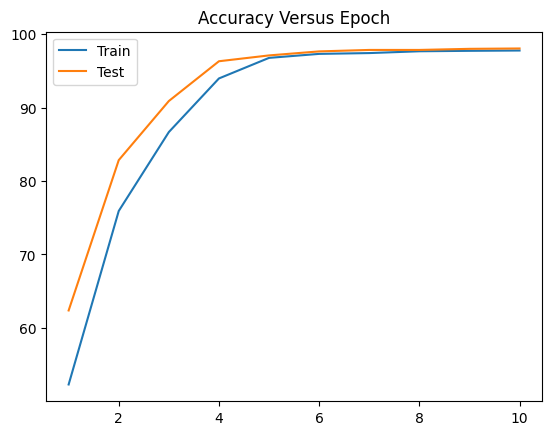

<Figure size 640x480 with 0 Axes>

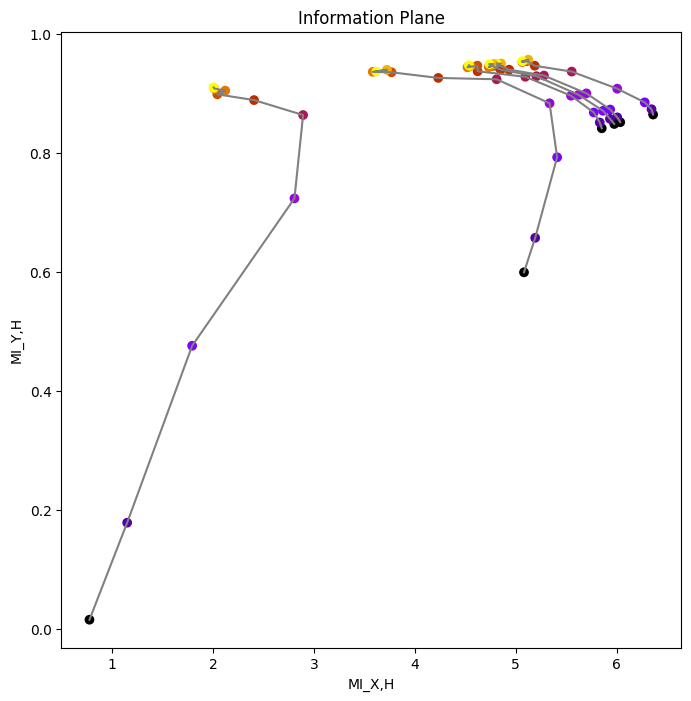

In [ ]:
train_accuracy = []
test_accuracy = []

# mutual informations for every epoch and every layer
layers = len(list(model.children()))
MI_XH = torch.zeros(epochs, layers)
MI_YH = torch.zeros(epochs, layers)

# iterate over epochs
for epoch in range(epochs):
    # run model on full train dataset
    for images, labels in train_loader_full:
        images, labels = images.to(device), labels.to(device)

    h_list = model(images)

    # calculate mutual information
    for layer, h in enumerate(h_list):
        # discretize images and representations
        bins = np.linspace(0, 1, n_bins+1)
        x_ = np.digitize(images.cpu(), bins)
        if layer == layers-1:
            h = torch.exp(h)
            bins = np.linspace(0, 1, n_bins+1)
        else:
            bins = np.linspace(-1, 1, n_bins+1)
        h_ = np.digitize(h.cpu().detach().numpy(), bins)
        y_ = labels.cpu()

        # calculate discrete probabilities
        p_X = Counter()
        p_Y = Counter()
        p_H = Counter()
        p_XH = Counter()
        p_YH = Counter()

        for x_i, h_i, y_i in zip(x_, h_, y_):
            def totuple(a):
                try:
                    return tuple(totuple(i) for i in a)
                except:
                    return a.item()

            unit = 1./len(images)

            p_X[totuple(x_i)]                   += unit
            p_Y[totuple(y_i)]                   += unit
            p_H[totuple(h_i)]                   += unit
            p_XH[(totuple(x_i), totuple(h_i))]  += unit
            p_YH[(totuple(y_i), totuple(h_i))]  += unit

        # ADD CODE HERE
        I_XH = sum(p_x_h * math.log2(p_x_h / (p_X[x] * p_H[h])) for (x, h), p_x_h in p_XH.items())
        I_YH = sum(p_y_h * math.log2(p_y_h / (p_Y[y] * p_H[h])) for (y, h), p_y_h in p_YH.items())
        MI_XH[epoch, layer] = I_XH
        MI_YH[epoch, layer] = I_YH
    # train phase
    model.train()
    accuracy = 0
    N = 0

    # iterate over train data
    for batch_idx, (images, labels) in enumerate(train_loader, start=1):
        images, labels = images.to(device), labels.to(device)

        # forward pass
        h1, h2, h3, h4, h5, h6 = model(images)
        loss = loss_function(h6, labels)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # check if predicted labels are equal to true labels
        predicted_labels = torch.argmax(h6,dim=1)
        accuracy += torch.sum((predicted_labels==labels).float()).item()
        N += images.shape[0]

        print('Train\t\tEpoch: {} \t'
              'Batch {}/{} ({:.0f}%) \t'
              'Batch Loss: {:.6f} \t'
              'Batch Accuracy: {:.6f}'.format(
                  epoch+1,
                  batch_idx,
                  len(train_loader),
                  100. * batch_idx / len(train_loader),
                  loss.item(),
                  100. * accuracy/N))

    train_accuracy.append(100. * accuracy/N)

    scheduler.step()

    # test phase
    model.eval()
    accuracy = 0
    N = 0

    # iterate over test data
    for batch_idx, (images, labels) in enumerate(test_loader, start=1):
        images, labels = images.to(device), labels.to(device)

        # forward pass
        h1, h2, h3, h4, h5, h6 = model(images)

        # check if predicted labels are equal to true labels
        predicted_labels = torch.argmax(h6,dim=1)
        accuracy += torch.sum((predicted_labels==labels).float()).item()
        N += images.shape[0]
    test_accuracy.append(100. * accuracy/N)
    print(test_accuracy[-1])

torch.save(model.state_dict(), 'trained_model.pth')
# plot results
plt.figure()
plt.title('Accuracy Versus Epoch')
plt.plot(range(1, epochs+1), train_accuracy, label='Train')
plt.plot(range(1, epochs+1), test_accuracy, label='Test')
plt.legend()

plt.figure()
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlabel('MI_X,H')
ax.set_ylabel('MI_Y,H')
title = ax.set_title('Information Plane')
cmap = plt.get_cmap('gnuplot', epochs)
colors = [cmap(i) for i in np.linspace(0, 1, epochs)]
ax.plot(MI_XH, MI_YH, '-', color='gray')
for layer in range(layers):
    im = ax.scatter(MI_XH[:,layer], MI_YH[:,layer], c=colors)

**3. Pruned Model Definition and Pruning Implementation**

This section defines the `PrunedModel` class, which has the same architecture as the baseline but incorporates pruning methods from `torch.nn.utils.prune`.

**Pruning Techniques:**
*   The class includes helper methods for different pruning types:
    *   `unstructured_pruning`: Uses L1 norm to prune individual weights (`prune.l1_unstructured`).
    *   `structured_pruning`: Uses L2 norm to prune entire neurons/channels (`prune.ln_structured`, `dim=0` prunes output neurons).
    *   `prune_entire_network`: Applies global unstructured weight pruning across all layers.
    *   `prune_entire_network_neuron`: Applies global structured neuron pruning across all layers.
*   **Pruning is applied *at initialization* within the `__init__` method.**
*   **Experimentation:** To replicate the results from the report (Figures 1, 2, 3), **modify the `__init__` method** to call the desired pruning function on specific layers (e.g., `self.unstructured_pruning(self.fc2, amount=0.95)`) or globally (e.g., `self.prune_entire_network(0.65)` or `self.prune_entire_network_neuron(0.35)`). *Currently, it's set to global neuron pruning with 35% sparsity.*
*   The dataset preparation and optimizer setup are repeated for the pruned model.

In [ ]:
class PrunedModel(nn.Module):
    def __init__(self):
        super(PrunedModel, self).__init__()
        self.fc1 = nn.Linear(12, 10)
        self.fc2 = nn.Linear(10, 7)
        self.fc3 = nn.Linear(7, 5)
        self.fc4 = nn.Linear(5, 4)
        self.fc5 = nn.Linear(4, 3)
        self.fc6 = nn.Linear(3, 2)

        #self.structured_pruning(self.fc5, amount = 0.8, dim=0)
        #self.unstructured_pruning(self.fc5, amount = 0.95)
        #self.unstructured_pruning(self.fc1, amount = 0.95)
        #self.unstructured_pruning(self.fc6, amount = 0.95)
        #self.prune_entire_network(0.65)
        self.prune_entire_network_neuron(0.35)
    def forward(self, x):
        h1 = torch.tanh(self.fc1(x))
        h2 = torch.tanh(self.fc2(h1))
        h3 = torch.tanh(self.fc3(h2))
        h4 = torch.tanh(self.fc4(h3))
        h5 = torch.tanh(self.fc5(h4))
        h6 = F.log_softmax(self.fc6(h5), dim=1)
        return h1, h2, h3, h4, h5, h6

    def prune(self, pruning_percentage):
        parameters_to_prune = (
            (self.fc1, 'weight'),
            (self.fc2, 'weight'),
            (self.fc3, 'weight'),
            (self.fc4, 'weight'),
            (self.fc5, 'weight'),
            (self.fc6, 'weight'),
        )

        prune.global_unstructured(
            parameters_to_prune,
            pruning_method=prune.L1Unstructured,
            amount=pruning_percentage,
        )

    def structured_pruning(self, layer, amount, dim):
        prune.ln_structured(layer, name="weight", amount=amount, n=2, dim=dim)
    def unstructured_pruning(self, layer, amount):
        # Create a pruning object for the layer
        prune.l1_unstructured(layer, name='weight', amount=amount)
    def prune_entire_network(self, amount):
        for layer in self.children():
            if isinstance(layer, nn.Linear):
                # For linear layers, apply unstructured pruning
                parameters_to_prune = ((layer, 'weight'),)
                prune.global_unstructured(
                    parameters_to_prune,
                    pruning_method=prune.L1Unstructured,
                    amount=amount,
                )
    def prune_entire_network_neuron(self, amount):
        for layer in self.children():
            if isinstance(layer, (nn.Linear, nn.Conv2d)):
                # For both linear and convolutional layers, apply structured pruning to weights
                prune.ln_structured(layer, name="weight", amount=amount, n=2, dim=0)

pruned_model = PrunedModel().to(device)




def process_dataset(dataset):
    # keep only images of two digits
    digit1 = 0
    digit2 = 2

    indices = (dataset.targets == digit1) | (dataset.targets == digit2)
    dataset.data, dataset.targets = dataset.data[indices], dataset.targets[indices]

    dataset.targets[dataset.targets == digit1] = 0
    dataset.targets[dataset.targets == digit2] = 1

    dataset = TensorDataset(dataset.data.reshape(-1, 28*28), dataset.targets)

    return dataset

transform = transforms.ToTensor()
train_dataset = process_dataset(datasets.MNIST('../data', download=True, train=True, transform=transform))
test_dataset = process_dataset(datasets.MNIST('../data', download=True, train=False, transform=transform))

# use PCA to reduce to 12 dimensions
pca = PCA(n_components=12)
pca.fit(train_dataset.tensors[0])
train_dataset.tensors = (torch.from_numpy(pca.transform(train_dataset.tensors[0])).float(), train_dataset.tensors[1])
test_dataset.tensors = (torch.from_numpy(pca.transform(test_dataset.tensors[0])).float(), test_dataset.tensors[1])

# dataset loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

train_loader_full = torch.utils.data.DataLoader(
    train_dataset, batch_size=len(train_loader.dataset), shuffle=False, drop_last=False)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

# loss function
loss_function = nn.NLLLoss()

# optimizer
optimizer = optim.SGD(pruned_model.parameters(),
                      lr=lr,
                      momentum=momentum,
                      weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

**4. Training the Pruned Model and Calculating Mutual Information**

This code block trains the **pruned model** (defined and pruned in the previous cell).

**Process:**
*   The training loop structure is identical to the baseline model's loop (Cell 5).
*   It calculates `I(X;H)` and `I(Y;H)` for the *pruned* network's layers at each epoch.
*   It trains the pruned network using SGD.
*   It plots the accuracy curves and the Information Plane for the pruned model.

**Analysis:**
*   Compare the resulting Information Plane and accuracy plots with those from the baseline model (output of Cell 5).
*   Relate the observations to the different pruning scenarios discussed in the report (Figures 1, 2, 3 and corresponding accuracy plots in Figures 5, 6, 7). Observe how different pruning strategies and levels affect MI dynamics and final accuracy.

Train		Epoch: 1 	Batch 1/23 (4%) 	Batch Loss: 0.694506 	Batch Accuracy: 49.609375
Train		Epoch: 1 	Batch 2/23 (9%) 	Batch Loss: 0.692156 	Batch Accuracy: 51.953125
Train		Epoch: 1 	Batch 3/23 (13%) 	Batch Loss: 0.694359 	Batch Accuracy: 51.302083
Train		Epoch: 1 	Batch 4/23 (17%) 	Batch Loss: 0.694490 	Batch Accuracy: 50.976562
Train		Epoch: 1 	Batch 5/23 (22%) 	Batch Loss: 0.695266 	Batch Accuracy: 50.429688
Train		Epoch: 1 	Batch 6/23 (26%) 	Batch Loss: 0.695434 	Batch Accuracy: 49.934896
Train		Epoch: 1 	Batch 7/23 (30%) 	Batch Loss: 0.693756 	Batch Accuracy: 50.083705
Train		Epoch: 1 	Batch 8/23 (35%) 	Batch Loss: 0.695061 	Batch Accuracy: 49.780273
Train		Epoch: 1 	Batch 9/23 (39%) 	Batch Loss: 0.693751 	Batch Accuracy: 49.826389
Train		Epoch: 1 	Batch 10/23 (43%) 	Batch Loss: 0.694312 	Batch Accuracy: 49.765625
Train		Epoch: 1 	Batch 11/23 (48%) 	Batch Loss: 0.693810 	Batch Accuracy: 49.751420
Train		Epoch: 1 	Batch 12/23 (52%) 	Batch Loss: 0.693845 	Batch Accuracy: 49.788411
Tra

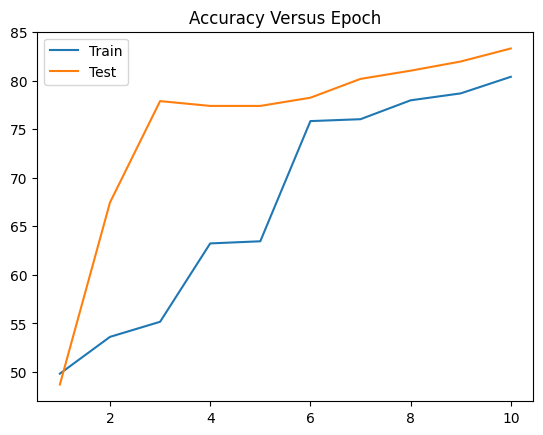

<Figure size 640x480 with 0 Axes>

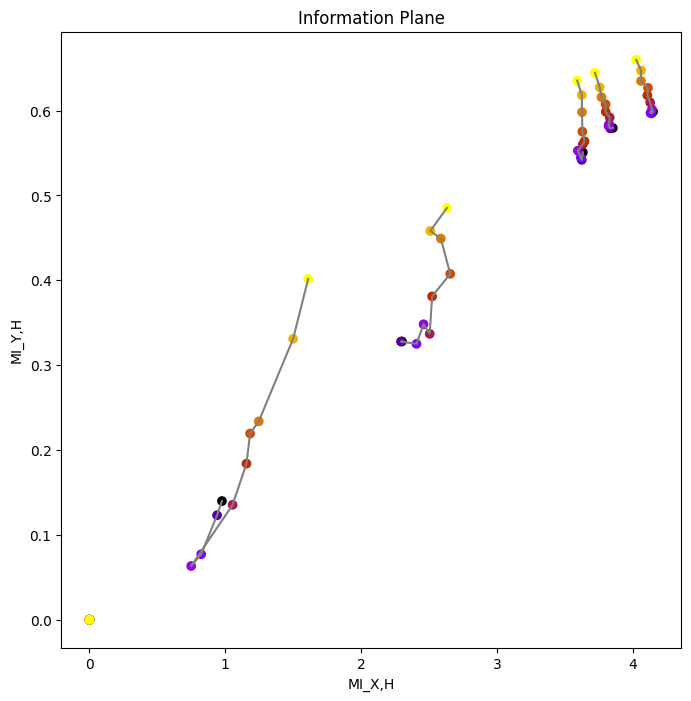

In [ ]:
train_accuracy = []
test_accuracy = []

# mutual informations for every epoch and every layer
layers = len(list(pruned_model.children()))
MI_XH = torch.zeros(epochs, layers)
MI_YH = torch.zeros(epochs, layers)

# iterate over epochs
for epoch in range(epochs):
    # run model on full train dataset
    for images, labels in train_loader_full:
        images, labels = images.to(device), labels.to(device)

    h_list = pruned_model(images)

    # calculate mutual information
    for layer, h in enumerate(h_list):
        # discretize images and representations
        bins = np.linspace(0, 1, n_bins+1)
        x_ = np.digitize(images.cpu(), bins)
        if layer == layers-1:
            h = torch.exp(h)
            bins = np.linspace(0, 1, n_bins+1)
        else:
            bins = np.linspace(-1, 1, n_bins+1)
        h_ = np.digitize(h.cpu().detach().numpy(), bins)
        y_ = labels.cpu()

        # calculate discrete probabilities
        p_X = Counter()
        p_Y = Counter()
        p_H = Counter()
        p_XH = Counter()
        p_YH = Counter()

        for x_i, h_i, y_i in zip(x_, h_, y_):
            def totuple(a):
                try:
                    return tuple(totuple(i) for i in a)
                except:
                    return a.item()

            unit = 1./len(images)

            p_X[totuple(x_i)]                   += unit
            p_Y[totuple(y_i)]                   += unit
            p_H[totuple(h_i)]                   += unit
            p_XH[(totuple(x_i), totuple(h_i))]  += unit
            p_YH[(totuple(y_i), totuple(h_i))]  += unit

        # ADD CODE HERE
        I_XH = sum(p_x_h * math.log2(p_x_h / (p_X[x] * p_H[h])) for (x, h), p_x_h in p_XH.items())
        I_YH = sum(p_y_h * math.log2(p_y_h / (p_Y[y] * p_H[h])) for (y, h), p_y_h in p_YH.items())
        MI_XH[epoch, layer] = I_XH
        MI_YH[epoch, layer] = I_YH
    # train phase
    pruned_model.train()
    accuracy = 0
    N = 0

    # iterate over train data
    for batch_idx, (images, labels) in enumerate(train_loader, start=1):
        images, labels = images.to(device), labels.to(device)

        # forward pass
        h1, h2, h3, h4, h5, h6 = pruned_model(images)
        loss = loss_function(h6, labels)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # check if predicted labels are equal to true labels
        predicted_labels = torch.argmax(h6,dim=1)
        accuracy += torch.sum((predicted_labels==labels).float()).item()
        N += images.shape[0]

        print('Train\t\tEpoch: {} \t'
              'Batch {}/{} ({:.0f}%) \t'
              'Batch Loss: {:.6f} \t'
              'Batch Accuracy: {:.6f}'.format(
                  epoch+1,
                  batch_idx,
                  len(train_loader),
                  100. * batch_idx / len(train_loader),
                  loss.item(),
                  100. * accuracy/N))

    train_accuracy.append(100. * accuracy/N)

    scheduler.step()

    # test phase
    pruned_model.eval()
    accuracy = 0
    N = 0

    # iterate over test data
    for batch_idx, (images, labels) in enumerate(test_loader, start=1):
        images, labels = images.to(device), labels.to(device)

        # forward pass
        h1, h2, h3, h4, h5, h6 = pruned_model(images)

        # check if predicted labels are equal to true labels
        predicted_labels = torch.argmax(h6,dim=1)
        accuracy += torch.sum((predicted_labels==labels).float()).item()
        N += images.shape[0]
    test_accuracy.append(100. * accuracy/N)
    print(test_accuracy[-1])

# plot results
plt.figure()
plt.title('Accuracy Versus Epoch')
plt.plot(range(1, epochs+1), train_accuracy, label='Train')
plt.plot(range(1, epochs+1), test_accuracy, label='Test')
plt.legend()

plt.figure()
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlabel('MI_X,H')
ax.set_ylabel('MI_Y,H')
title = ax.set_title('Information Plane')
cmap = plt.get_cmap('gnuplot', epochs)
colors = [cmap(i) for i in np.linspace(0, 1, epochs)]
ax.plot(MI_XH, MI_YH, '-', color='gray')
for layer in range(layers):
    im = ax.scatter(MI_XH[:,layer], MI_YH[:,layer], c=colors)

**5. Inspecting Pruned Weights (Example)**

This cell provides a simple way to visually verify that pruning has been applied. It prints the weight matrix (or weight tensor if structured pruning was applied) of a specific layer (e.g., `fc4`). After pruning, many entries in this tensor should be exactly zero.

In [ ]:
print(pruned_model.fc4.weight)

tensor([[-0.0000,  0.0000, -0.0000,  0.0000, -0.0000],
        [-0.0000, -0.0000,  0.0000, -0.0000,  0.0000],
        [ 0.4175,  0.5034, -0.3717,  0.5616,  0.8497],
        [ 0.0000, -0.0000,  0.0000,  0.0000,  0.0000]], device='cuda:0',
       grad_fn=<MulBackward0>)
